In [1]:
import numpy as np
%pylab inline
from tqdm import trange

Populating the interactive namespace from numpy and matplotlib


In [2]:
def fetch(url):
    import requests, gzip, os, hashlib, numpy
    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]
#import code from https://github.com/geohot/ai-notebooks/blob/master/mnist_from_scratch.ipynb

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
#neural net
class Neuralnet(torch.nn.Module):
    def __init__(self):
        super(Neuralnet, self).__init__()
        self.l1=nn.Linear(28*28,128)
        self.l2=nn.Linear(128,10)
        self.softmax=nn.LogSoftmax(dim=1)
    def forward(self,x):
        x=self.l1(x)
        x=F.relu(x)
        x=self.l2(x)
        x=self.softmax(x)
        return x

#splitting training and validation sets
rand = numpy.arange(60000)
numpy.random.shuffle(rand)
train_no=rand[:50000]
val_no=np.setdiff1d(rand,train_no)
X_train, X_val = X[train_no,:,:], X[val_no,:,:]
Y_train, Y_val = Y[train_no], Y[val_no]

In [5]:
model=Neuralnet()

In [6]:
val_no.shape


(10000,)

In [7]:
loss_func=nn.NLLLoss(reduction='none')
optimiser=torch.optim.SGD(model.parameters(),lr=0.001)
losses=[];accuracies=[];val_losses=[];val_accuracy=[]
bs=128
for i in range(5000):#5000 to figure out where it starts overfitting
    #batch for training
    sample_train=np.random.randint(0,X_train.shape[0],size=(bs))
    Xt=torch.tensor(X_train[sample_train].reshape((-1, 28*28))).float()
    Yt=torch.tensor(Y_train[sample_train]).long()
    #batch for validation
    sample_val=np.random.randint(0,X_val.shape[0],size=(bs))
    Xv=torch.tensor(X_val[sample_val].reshape((-1, 28*28))).float()
    Yv=torch.tensor(Y_val[sample_val]).long()
    
    model.zero_grad()
    
    out=model(Xt)
    #predicting for validation set
    Y_val_preds = torch.argmax(model(torch.tensor(X_val.reshape((-1, 28*28))).float()), dim=1).numpy()
    val_acc=(Y_val == Y_val_preds).mean()
    
    cat=torch.argmax(out,dim=1)
    accuracy=(cat==Yt).float().mean()
    loss=(loss_func(out,Yt)).mean()
    
    loss.backward()
    optimiser.step()
    losses.append(loss.item())
    val_accuracy.append(val_acc.item())
    accuracies.append(accuracy.item())
    
    print("accuracy %.2f val_acc %.2f"% (accuracy,val_acc))

    

accuracy 0.05 val_acc 0.06
accuracy 0.19 val_acc 0.20
accuracy 0.23 val_acc 0.19
accuracy 0.27 val_acc 0.26
accuracy 0.28 val_acc 0.32
accuracy 0.48 val_acc 0.48
accuracy 0.48 val_acc 0.53
accuracy 0.60 val_acc 0.54
accuracy 0.56 val_acc 0.57
accuracy 0.55 val_acc 0.59
accuracy 0.55 val_acc 0.60
accuracy 0.60 val_acc 0.62
accuracy 0.70 val_acc 0.63
accuracy 0.66 val_acc 0.64
accuracy 0.62 val_acc 0.65
accuracy 0.70 val_acc 0.66
accuracy 0.66 val_acc 0.68
accuracy 0.67 val_acc 0.68
accuracy 0.64 val_acc 0.68
accuracy 0.62 val_acc 0.68
accuracy 0.69 val_acc 0.69
accuracy 0.68 val_acc 0.70
accuracy 0.61 val_acc 0.70
accuracy 0.73 val_acc 0.70
accuracy 0.68 val_acc 0.71
accuracy 0.73 val_acc 0.72
accuracy 0.77 val_acc 0.71
accuracy 0.73 val_acc 0.72
accuracy 0.77 val_acc 0.73
accuracy 0.73 val_acc 0.73
accuracy 0.73 val_acc 0.73
accuracy 0.78 val_acc 0.73
accuracy 0.75 val_acc 0.74
accuracy 0.70 val_acc 0.73
accuracy 0.76 val_acc 0.74
accuracy 0.73 val_acc 0.75
accuracy 0.76 val_acc 0.75
a

In [9]:
#testing pred after 5000 epochs is 95%? how?
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
(Y_test == Y_test_preds).mean()

0.9565

In [8]:
X_val.shape


(10000, 28, 28)

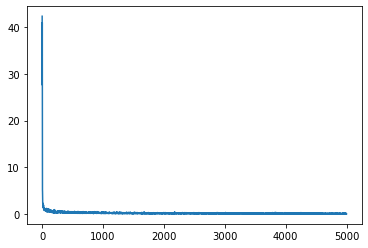

In [8]:



plot(losses)
plot(val_losses)
#plot(accuracies)
#plot(legend(["loss", "accur","validloss"]))


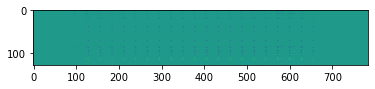

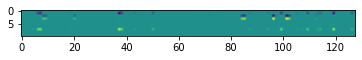

In [10]:
samp = [0,1,2,3]
model.zero_grad()
out = model(torch.tensor(X_test[samp].reshape((-1, 28*28))).float())
out.retain_grad()
loss = loss_func(out, torch.tensor(Y_test[samp]).long()).mean()
loss.retain_grad()
loss.backward()
imshow(model.l1.weight.grad)
figure()
imshow(model.l2.weight.grad)

In [11]:
??model